<a href="https://colab.research.google.com/github/lg960214/DACON_Seoul_6/blob/develop/Geo_PipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas #geopandas
!pip install xlrd==1.2.0 #xls 읽기 위해
!pip install rtree pygeos
!pip install pydeck
#matplotlib 한글깨짐방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 1 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/libe

In [2]:
#필수 패키지 임포트
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
import os
import pydeck as pdk
import matplotlib.font_manager as fm 
#fm._rebuild() 
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [74]:
def read_df(y=2022, m=9, sheet=2): #sheet 2는 월별 무임유임 승하차 데이터, sheet3은 일별시간별 승하차데이터, 4는 노인 일별 시간대별 승하차 데이터.
  rootdir = '/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료' #승하차 데이터 루트 경로
  dir_subway_eld = '/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20220531.csv'

  sub_dirs = {} #sub_dirs[year][month]로 해당 월의 xls 파일경로를 가져올 수 있도록 딕셔너리 만듦.
  for year in os.listdir(rootdir):
    sub_sub_dirs = {}
    for month in os.listdir(os.path.join(rootdir, year)):
      sub_sub_dirs[int(month.split(' ')[1][:2])] = os.path.join(rootdir, year, month)
    sub_dirs[int(year)] = sub_sub_dirs

  if sheet < 4:
    df = pd.read_excel(sub_dirs[y][m], sheet_name=sheet, thousands=',')
  elif sheet==4:
    df = pd.read_csv(dir_subway_eld, encoding='cp949')

  if sheet==2:
    df = df.drop(columns=['호선명', '역ID', '작업일시', '사용월'])
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  if sheet==3:
    df = df.iloc[1:, 3:-1]
    c = ['지하철역']
    for i in range(24):
      c.append(f'{(i+3)%24}시승차')
      c.append(f'{(i+3)%24}시하차')
    df.columns = c
    temp = df['지하철역']
    df = df[df.columns[1:]].astype('int')
    df['지하철역'] = temp
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  if sheet==4:
    df = df.drop(columns=['연번', '역번호', '구분'])
    df['연월'] = df['일자'].apply(lambda x : '-'.join(x.split('-')[:2]))
    df = df[df['연월']=='2022-05']
    df = df.groupby(by='역명').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  return df

In [4]:
def to_geodf(df, epsg=5179):
  dir_station = '/content/drive/MyDrive/DACON6/지하철 시설 정보/서울시 역사마스터 정보.csv' #역 좌표 데이터
  df_station = pd.read_csv(dir_station, encoding='cp949')
  df_station = df_station.drop(columns=['역사_ID', '호선'])
  df_station = df_station.groupby(by='역사명').mean()
  df_station['지하철역'] = df_station.index
  df_station.index = list(range(len(df_station))) #읽어와서 필요없는 컬럼 지우고 중복되는 역은 좌표를 평균냄

  df = pd.merge(df, df_station, on='지하철역') #역 좌표 데이터를 승하차 데이터와 통합

  s = gpd.GeoSeries([Point(x, y) for x, y in zip(df['위도'], df['경도'])]) #위도 경도 데이터를 GeoSeries Point 로 변환
  
  geodf = gpd.GeoDataFrame(df, geometry=s) # GeoDataFrame 생성
  geodf.crs = 'epsg:4326' #현재 좌표계는 위도경도(epsg4326)
  geodf = geodf.to_crs(epsg=epsg) #경계 데이터 좌표계는(epsg5179) 이걸로 변환
  geodf = geodf.drop(columns=['위도', '경도']) #기존 위도 경도는 제거
  
  return geodf

In [5]:
def to_density(geodf): #True 일 경우 geojson 파일로 리턴
  geodf = geodf.drop(columns=['지하철역'])

  dir_shp = '/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp' #.shp 파일 경로(서울시 행정구역 단위 경계 데이터)
  seoul = gpd.read_file(dir_shp) #경계 데이터 읽기
  seoul.crs = 'epsg:5179' # 좌표계

  temp = []
  #geodf을 통해 경계 구역 내 지하철 역의 데이터를 모두 더해 밀도로 변환
  station_pos = geodf.geometry
  for i, g in enumerate(seoul.geometry):
    idx = station_pos.within(g)
    temp.append(geodf[idx].iloc[:, :-1].sum().to_numpy().T)

  temp = np.stack(temp)
  c = geodf.columns[:-1]
  for i, col in enumerate(c):
    seoul[col] = temp[:, i]

  seoul = seoul.to_crs(epsg=4326)

  return seoul, seoul.to_json()

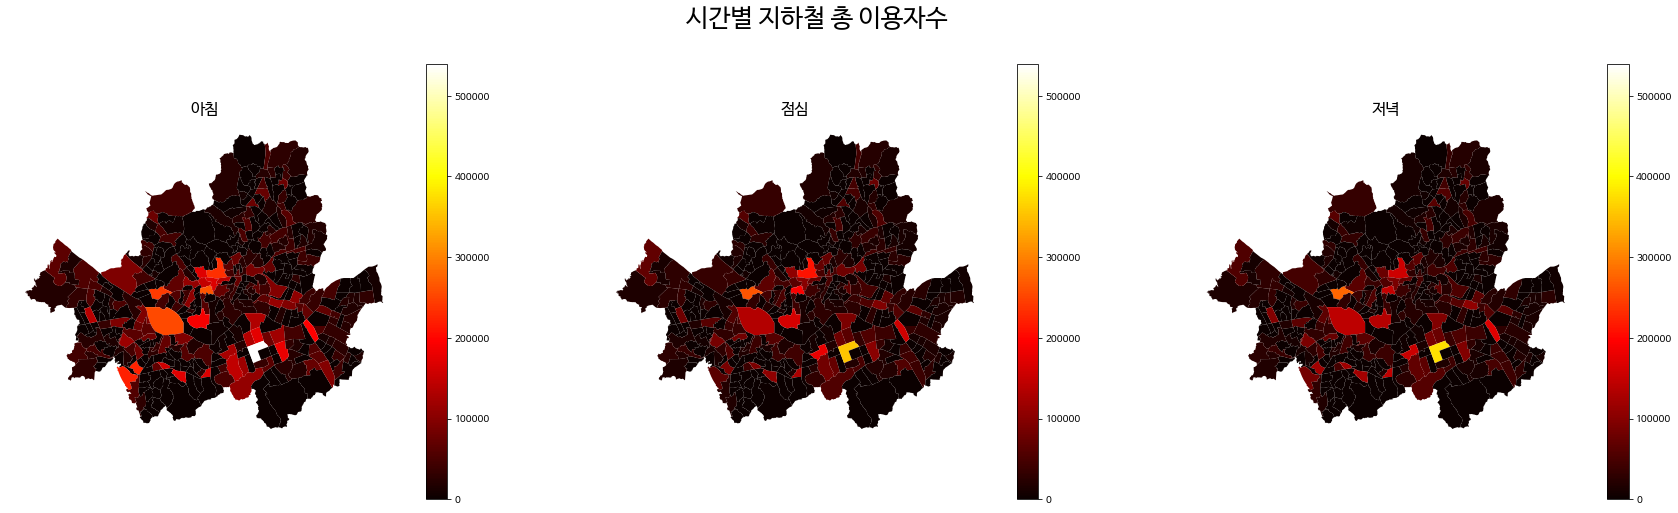

In [89]:
#시간대별 전체 승하차
df = read_df(2022, 5, 3)

time_dict = {'아침승하차':['7시승차', '8시승차', '7시하차', '8시하차'], '점심승하차':['14시승차','15시승차', '14시하차','15시하차'],'저녁승하차':['18시승차', '19시승차', '18시하차', '19시하차']}
for s in ['아침승하차','점심승하차', '저녁승하차']:
  df[s] = df[time_dict[s]].mean(axis=1)

geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

plt.rc('font', family='NanumBarunGothic') 
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('시간별 지하철 총 이용자수', fontsize=25)

axs[0].axis('off')
axs[0].set_title('아침', fontsize=16)
seoul.plot('아침승하차', ax=axs[0], vmin=0, vmax=vm, cmap='hot', legend=True)

axs[1].axis('off')
axs[1].set_title('점심', fontsize=16)
seoul.plot('점심승하차', ax=axs[1], vmin=0, vmax=vm, cmap='hot', legend=True)

axs[2].axis('off')
axs[2].set_title('저녁', fontsize=16)
seoul.plot('저녁승하차', ax=axs[2], vmin=0, vmax=vm, cmap='hot', legend=True)

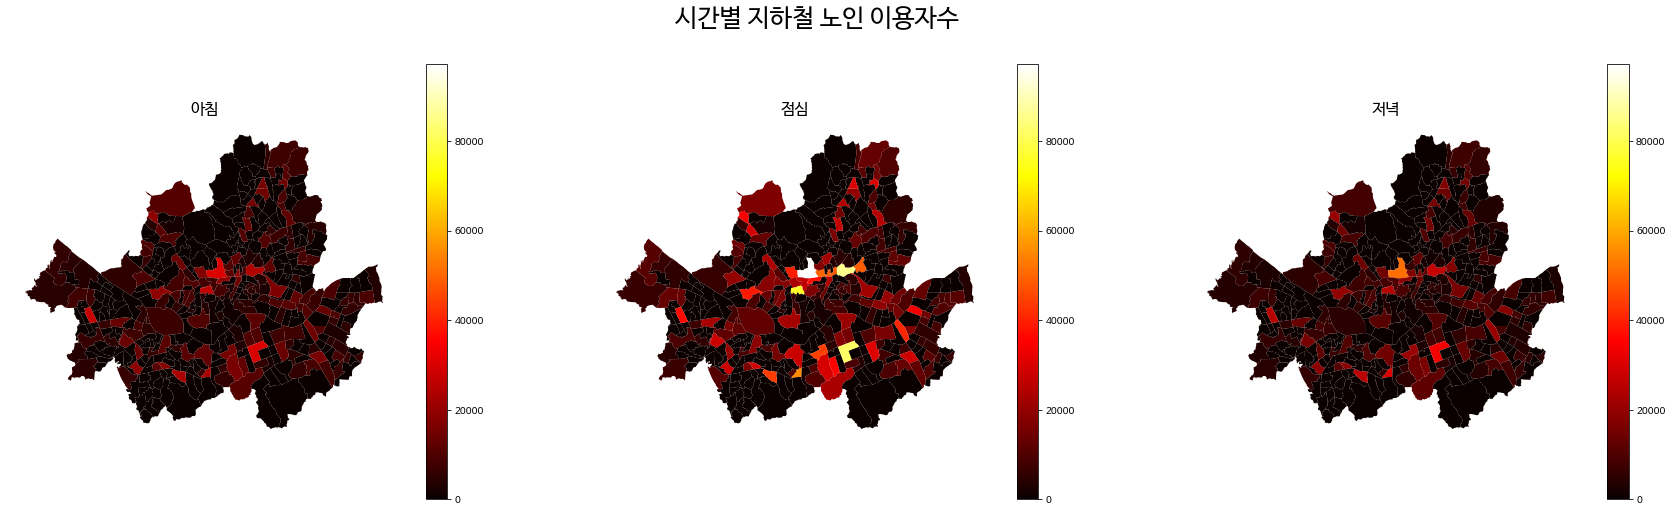

In [90]:
#노인 이용자의 시간별 밀도 자료
df = read_df(2022, 5, 4)
time_dict = {'아침승하차':['07시-08시', '08시-09시'], '점심승하차':['14시-15시', '15시-16시'],'저녁승하차':['18시-19시', '19시-20시']}
for s in ['아침승하차','점심승하차', '저녁승하차']:
  df[s] = df[time_dict[s]].mean(axis=1)

geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

plt.rc('font', family='NanumBarunGothic') 
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('시간별 지하철 노인 이용자수', fontsize=25)

axs[0].axis('off')
axs[0].set_title('아침', fontsize=16)
seoul.plot('아침승하차', ax=axs[0], vmin=0, vmax=vm, cmap='hot', legend=True)

axs[1].axis('off')
axs[1].set_title('점심', fontsize=16)
seoul.plot('점심승하차', ax=axs[1], vmin=0, vmax=vm, cmap='hot', legend=True)

axs[2].axis('off')
axs[2].set_title('저녁', fontsize=16)
seoul.plot('저녁승하차', ax=axs[2], vmin=0, vmax=vm, cmap='hot', legend=True)

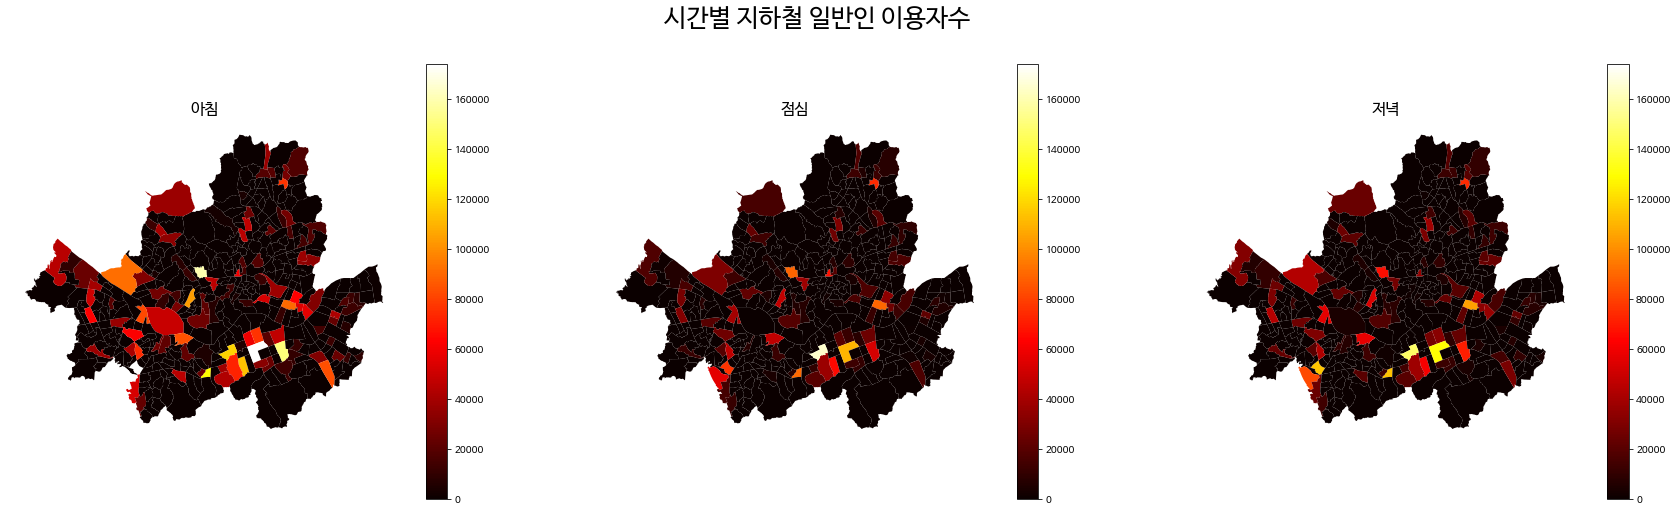

In [91]:
#일반인 이용자의 시간별 밀도 자료
df1 = read_df(2022, 5, 3)

time_dict = {'아침승하차':['7시승차', '8시승차', '7시하차', '8시하차'], '점심승하차':['14시승차','15시승차', '14시하차','15시하차'],'저녁승하차':['18시승차', '19시승차', '18시하차', '19시하차']}
for s in ['아침승하차','점심승하차', '저녁승하차']:
  df1[s] = df1[time_dict[s]].mean(axis=1)

df2 = read_df(2022, 5, 4)
time_dict = {'아침승하차':['07시-08시', '08시-09시'], '점심승하차':['14시-15시', '15시-16시'],'저녁승하차':['18시-19시', '19시-20시']}
for s in ['아침승하차','점심승하차', '저녁승하차']:
  df2[s] = df2[time_dict[s]].mean(axis=1)

df = df1.copy()

for s in ['아침승하차','점심승하차', '저녁승하차']:
  df[s] = df1[s] - df2[s]

geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

plt.rc('font', family='NanumBarunGothic') 
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('시간별 지하철 일반인 이용자수', fontsize=25)

axs[0].axis('off')
axs[0].set_title('아침', fontsize=16)
seoul.plot('아침승하차', ax=axs[0], vmin=0, vmax=vm, cmap='hot', legend=True)

axs[1].axis('off')
axs[1].set_title('점심', fontsize=16)
seoul.plot('점심승하차', ax=axs[1], vmin=0, vmax=vm, cmap='hot', legend=True)

axs[2].axis('off')
axs[2].set_title('저녁', fontsize=16)
seoul.plot('저녁승하차', ax=axs[2], vmin=0, vmax=vm, cmap='hot', legend=True)